In [ ]:
#take boxes determined by marisol from kathleens biforcation data and calculate average environmental information for them
#want to calculate average SST, SSS, u^2+v^2, and var(u^2+v^2)
#recaluclate spd, dir from u,v after averaging in subset routine
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import os
from os.path import exists
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import *; from dateutil.relativedelta import *
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter
import sys
import geopandas as gpd
import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

sys.path.append('./subroutines/')
from shapefile_reading import explode_polygon
from shapefile_reading import get_pices_mask


In [ ]:

dir_data_oscar = 'F:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_data_sss='F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/'
dir_data_sst = 'F:/data/sst/cmc/CMC0.2deg/v2/monthly/' 
dir_data_ccmp='F:/data/sat_data/ccmp/v02.0/'
dir_data_mld='F:/data/model_data/godas/'
dir_figs = 'F:/data/NASA_biophysical/pices/figures/'
dir_timeseries = 'F:/data/NASA_biophysical/timeseries_data/'
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/'
#oscar - reran all monthly fies & climatology, updated through 2018, 2/1/2019
#ccmp - added RVort, from 6-hourly creating new monthly and climatology 2/1/2019 
#sst - updated all files, reprocessed monthly, climatology 2/1/2019
#sss - rerunning 2018, cal climatology 2/2/2019
#ssh - re running 2018 , cal climatology 2/2/2019
#mld - reran climatology, downloaded final 2018 file 2/1/2019

def weighted_mean_of_subset(ds,data_in,cond):
    #ds = input xarray data to have weighted mean
    #data_in = ds.data some data variable that has a nan mask applied where no data lat,lon dims
    #subset condition
    R = 6.37e6 #radius of earth in m
    # we know already that the spacing of the points is 1/4 degree latitude
    grid_dy,grid_dx = (ds.lat[0]-ds.lat[1]).data,(ds.lon[0]-ds.lon[1]).data
    dϕ = np.deg2rad(grid_dy)
    dλ = np.deg2rad(grid_dx)
    dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) #dA.plot()
    pixel_area = dA.where(cond)  #pixel_area.plot()
    pixel_area = pixel_area.where(np.isfinite(data_in))
    total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
    data_weighted_mean = (ds * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area
    return data_weighted_mean


def get_climatology_filename(data_type):
    if data_type=='oscar':
        filename = dir_data_oscar + 'climatology_1993_2018_monthly_data_oscar.nc'        
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + 'clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc'
    if data_type=='sst':
        filename = dir_data_sst + 'monthly_climatology_1992_2017_120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/climatology_1988_2018_CCMP_Wind_Analysis_L3.0.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'monthly_climatology_dbss_obml_1992_2018.nc'
    return filename

def get_data_filename(data_type,lyr):
    if data_type == 'oscar':
        filename = dir_data_oscar + str(lyr) + 'monthly_data_oscar.nc'
    if data_type=='sss' or data_type=='ssh':
        filename = dir_data_sss + str(lyr) + '/'+ 'year_subset_mercatorglorys12v1_gl12_mean_' + str(lyr) + '.nc'
        if lyr==2018:
            filename = 'F:/data/model_data/CMEM/global-analysis-forecast-phys_001_015/monthly/year_subset_metoffice_coupled_orca025_GL4_SAL_b2018_dm20180208.nc'
    if data_type=='sst':
        filename = dir_data_sst + str(lyr) + 'monthly_average_' + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    if data_type == 'ccmp':
        filename = dir_data_ccmp + 'monthly/CCMP_Wind_Analysis_' + str(lyr) + '_V02.0_L3.0_RSS.nc'
    if data_type == 'mld':
        filename = dir_data_mld + 'dbss_obml.' + str(lyr) + '.nc'
    return filename

def get_monthly_oscar(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('oscar',lyr)
    else:
        filename = get_climatology_filename('oscar')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.sel(lon=slice(20.0,379.9))
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
#    ds = ds.rename({'spd': 'data'})
    ds = ds.mean('depth')  #get rid of depth in index
    ds['spd']=(ds.u**2+ds.v**2)**.5
    ds['dir']=np.arctan2(ds.v,ds.u)* 180./pi
  #  ds=ds.drop('year')
    ds.close()
    return ds

def get_monthly_mld(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('mld',lyr)
    else:
        filename = get_climatology_filename('mld')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
 #   ds = ds.rename({'dbss_obml': 'data'})
    ds.close()
    return ds

def get_monthly_ccmp(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('ccmp',lyr)
    else:
        filename = get_climatology_filename('ccmp')
    print(filename)
    ds=xr.open_dataset(filename)
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
    ds['spd']=(ds.uwnd**2+ds.vwnd**2)**.5
    ds['dir']=np.arctan2(ds.vwnd,ds.uwnd)* 180./pi    
#    ds = ds.rename({'spd': 'data'})
    ds.close()
    return ds

def get_monthly_sst(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sst',lyr)
    else:
        filename = get_climatology_filename('sst')
    print(filename)
    ds=xr.open_dataset(filename)
 #   ds = ds.rename({'analysed_sst': 'data'})
    ds.close()
    return ds

def get_monthly_sss(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)
    else:
        filename = get_climatology_filename('sss')
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','zos'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['zos'])
    print(filename)
#    ds = ds.rename({'so': 'data'})
    ds.close()
    return ds

def get_monthly_ssh(lyr,iclim):
    if iclim==0:
        filename = get_data_filename('sss',lyr)  #same file as sss
    else:
        filename = get_climatology_filename('sss') #same file as sss
    print(filename)
    if lyr<2018:
        ds=xr.open_dataset(filename,drop_variables=['mlotst','bottomT','sithick','siconc','usi','vsi','thetao','uo','vo','so'])
    else:
        ds=xr.open_dataset(filename,drop_variables=['so'])
   # ds = ds.rename({'zos': 'data'})
    ds.close()
    return ds


#test reading -180 to 180, -90 to 90
iclim, lyr = 0,2017
#ds= get_monthly_oscar(lyr,iclim)
#ds= get_monthly_mld(lyr,iclim)
#ds= get_monthly_ccmp(lyr,iclim)
#ds= get_monthly_sst(lyr,iclim)
#ds= get_monthly_sss(lyr,iclim)
ds= get_monthly_ssh(lyr,iclim)
print(ds)
#ds.data[0,:,:].plot()
#ds.mlotst[0,:,:].plot(vmin=0,vmax=100) #density ocean mixed layer thickness
#ds.zos  #sea surface height above geod
#ds.uo  #eastward ocean velocity
#        if os.path.exists(filename):  
#            print(filename)


In [ ]:
ds.product_user_manual

In [ ]:
#here is the problem, in ice regions the area weighted mean isn't working right
#it needs to calculate the mask on a monthly basis rather than using same
#one for each month
lyr,iregion=2016,14
ds = get_monthly_mld(lyr,0)
ds2 = get_monthly_mld(lyr,1)
data_in = ds.dbss_obml#[9,:,:]
ds.dbss_obml[9,:,:].plot()
mask_interp = ds_mask.interp_like(ds,method='nearest')
cond = (mask_interp.region_mask==iregion)
R = 6.37e6 #radius of earth in m
# we know already that the spacing of the points is 1/4 degree latitude
grid_dy,grid_dx = (ds.lat[0]-ds.lat[1]).data,(ds.lon[0]-ds.lon[1]).data
dϕ = np.deg2rad(grid_dy)
dλ = np.deg2rad(grid_dx)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) #dA.plot()
pixel_area = dA.where(cond)  #pixel_area.plot()
pixel_area = pixel_area.where(np.isfinite(data_in))
total_ocean_area = pixel_area.sum(dim=('lon', 'lat'))
data_weighted_mean = (ds * pixel_area).sum(dim=('lon', 'lat')) / total_ocean_area


In [ ]:
#ds = get_monthly_ccmp(lyr,0)
#ds2 = get_monthly_ccmp(lyr,1)
##data_in = ds.uwnd#[0,:,:]
#ds2

In [3]:
#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
ds_pices

<xarray.Dataset>
Dimensions:      (lat: 1800, lon: 3600)
Coordinates:
  * lat          (lat) float64 -90.0 -89.9 -89.8 -89.7 ... 89.6 89.7 89.8 89.9
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
Data variables:
    region_mask  (lat, lon) float64 ...

In [96]:
darray = ['oscar','mld','ccmp','sst','sss','ssh']
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_dir = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_fig = 'F:/data/NASA_biophysical/pices/figures/'

#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()

#region = np.arange(0,21)
for itype in range(0,6):
    init_data = 0
    dtype = darray[itype]
    for lyr in range(1993,2019):
        iclim = 0
        if itype == 0:
            ds = get_monthly_oscar(lyr,0)
            ds2 = get_monthly_oscar(lyr,1)
            ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),
                                      'dir': (('time','lat','lon'),ds2.dir),
                                     'v': (('time','lat','lon'),ds2.v),
                                      'u': (('time','lat','lon'),ds2.u)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.u#[0,:,:]
        if itype == 1:
            ds = get_monthly_mld(lyr,0)
            ds2 = get_monthly_mld(lyr,1)
            ds2=xr.Dataset(data_vars={'dbss_obml': (('time','lat','lon'),ds2.dbss_obml),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.dbss_obml#[0,:,:]
        if itype == 2:
            ds = get_monthly_ccmp(lyr,0)
            ds2 = get_monthly_ccmp(lyr,1)
            ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),
                                      'dir': (('time','lat','lon'),ds2.dir),
                                     'vwnd': (('time','lat','lon'),ds2.vwnd),
                                      'uwnd': (('time','lat','lon'),ds2.uwnd),
                                      'rel_vorticity': (('time','lat','lon'),ds2.rel_vorticity)},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.uwnd#[0,:,:]
        if itype == 3:
            ds = get_monthly_sst(lyr,0)
            ds2 = get_monthly_sst(lyr,1)
            ds2=xr.Dataset(data_vars={'analysed_sst': (('time','lat','lon'),ds2.analysed_sst),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.analysed_sst#[0,:,:]
        if itype == 4:
            ds = get_monthly_sss(lyr,0)
            ds2 = get_monthly_sss(lyr,1)
            ds2=xr.Dataset(data_vars={'so': (('time','lat','lon'),ds2.so),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.so#[0,:,:]
        if itype == 5:
            ds = get_monthly_ssh(lyr,0)
            ds2 = get_monthly_ssh(lyr,1)
            ds2=xr.Dataset(data_vars={'zos': (('time','lat','lon'),ds2.zos),},
                            coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
            data_in = ds.zos#[0,:,:]
#now iterate over regions
        init_data2 = 0
        coord_region=[]
        for iregion in range(11,25):
            mask_interp = ds_pices.interp_like(ds,method='nearest')
            cond = (mask_interp.region_mask==iregion)
            ds_mean = weighted_mean_of_subset(ds,data_in,cond)
            ds_mean_clim = weighted_mean_of_subset(ds2,data_in,cond)
            if itype == 0:  #if currents or winds need to recal spd dir from means of u and v
                ds_mean['spd']=(ds_mean.u**2+ds_mean.v**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.v,ds_mean.u)* 180./pi                
                ds_mean_clim['spd']=(ds_mean_clim.u**2+ds_mean_clim.v**2)**.5
                ds_mean_clim['dir']=np.arctan2(ds_mean_clim.v,ds_mean_clim.u)* 180./pi                
            if itype==2:  #if currents or winds need to recal spd dir from means of u and v
                ds_mean['spd']=(ds_mean.uwnd**2+ds_mean.vwnd**2)**.5
                ds_mean['dir']=np.arctan2(ds_mean.vwnd,ds_mean.uwnd)* 180./pi                
                ds_mean_clim['spd']=(ds_mean_clim.uwnd**2+ds_mean_clim.vwnd**2)**.5
                ds_mean_clim['dir']=np.arctan2(ds_mean_clim.vwnd,ds_mean_clim.uwnd)* 180./pi                
#            ds_diff = ds_mean.groupby('time.month') - ds_mean_clim
            ds_diff = ds_mean - ds_mean_clim
            if init_data2==0:
                ds_box = ds_mean
                ds_box_clim = ds_diff
                coord_region.append(iregion)
                init_data2=1
            else:
                ds_box = xr.concat([ds_box,ds_mean],dim='region')
                ds_box_clim = xr.concat([ds_box_clim,ds_diff],dim='region')
                coord_region.append(iregion)
        if init_data==0:
            ds_newbox = ds_box
            ds_newbox_clim = ds_box_clim
            init_data=1
        else:
            ds_newbox = xr.concat([ds_newbox,ds_box],dim='time')
            ds_newbox_clim = xr.concat([ds_newbox_clim,ds_box_clim],dim='time')
        #print(ds_newbox.box)
    ds_newbox.coords['region']=coord_region
    ds_newbox_clim.coords['region']=coord_region
    print(ds_newbox)
    filename_out = dir_timeseries + dtype + '_pices_data_v2.nc'
    ds_newbox.to_netcdf(filename_out)
    filename_out_clim = dir_timeseries + dtype + '_pices_data_minus_clim_v2.nc'
    ds_newbox_clim.to_netcdf(filename_out_clim)
    print('out!')


F:/data/sat_data/oscar/L4/oscar_third_deg/1993monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/1994monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/1995monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/1996monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/1997monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/1998monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/1999monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2000monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2001monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2002monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2003monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2004monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2005monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2006monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2007monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2008monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2009monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2010monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2011monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2012monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2013monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2014monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2015monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2016monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2017monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
F:/data/sat_data/oscar/L4/oscar_third_deg/2018monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc
<xarray.Dataset>
Dimensions:  (region: 14, time: 312, year: 1872)
Coordinates:
  * year     (year) float64 1.993e+03 1.993e+03 ... 2.019e+03 2.019e+03
  * time     (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2018-12-31
  * region   (region) int32 11 12 13 14 15 16 17 18 19 20 21 22 23 24
Data variables:
    u        (region, time) float64 0.01722 0.01775 0.01414 ... 0.02485 0.02964
    v        (region, time) float64 -0.02191 -0.01825 ... -0.007956 -0.01442
    spd      (region, time) float64 0.02786 0.02545 0.0218 ... 0.0261 0.03296
    dir      (region, time) float64 -51.84 -45.8 -49.58 ... -13.22 -17.75 -25.94


PermissionError: [Errno 13] Permission denied: b'F:\\data\\NASA_biophysical\\timeseries_data\\oscar_pices_data_minus_clim_v2.nc'

In [92]:
darray = ['oscar','mld','ccmp','sst','sss','ssh']
dir_shp = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_dir = 'F:/data/NASA_biophysical/pices/shapefiles/pices/'
data_fig = 'F:/data/NASA_biophysical/pices/figures/'

#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
itype=5
for lyr in range(2003,2004):
    iclim = 0
    if itype == 0:
        ds = get_monthly_oscar(lyr,0)
        ds2 = get_monthly_oscar(lyr,1)
        ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),
                                  'dir': (('time','lat','lon'),ds2.dir),
                                 'v': (('time','lat','lon'),ds2.v),
                                  'u': (('time','lat','lon'),ds2.u)},
                        coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
        data_in = ds.u#[0,:,:]
    if itype == 1:
        ds = get_monthly_mld(lyr,0)
        ds2 = get_monthly_mld(lyr,1)
        ds2=xr.Dataset(data_vars={'dbss_obml': (('time','lat','lon'),ds2.dbss_obml),},
                        coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
        data_in = ds.dbss_obml#[0,:,:]
    if itype == 2:
        ds = get_monthly_ccmp(lyr,0)
        ds2 = get_monthly_ccmp(lyr,1)
        ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),
                                  'dir': (('time','lat','lon'),ds2.dir),
                                 'vwnd': (('time','lat','lon'),ds2.vwnd),
                                  'uwnd': (('time','lat','lon'),ds2.uwnd),
                                  'rel_vorticity': (('time','lat','lon'),ds2.rel_vorticity)},
                        coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
        data_in = ds.uwnd#[0,:,:]
    if itype == 3:
        ds = get_monthly_sst(lyr,0)
        ds2 = get_monthly_sst(lyr,1)
        ds2=xr.Dataset(data_vars={'analysed_sst': (('time','lat','lon'),ds2.analysed_sst),},
                        coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
        data_in = ds.analysed_sst#[0,:,:]
    if itype == 4:
        ds = get_monthly_sss(lyr,0)
        ds2 = get_monthly_sss(lyr,1)
        ds2=xr.Dataset(data_vars={'so': (('time','lat','lon'),ds2.so),},
                        coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
        data_in = ds.so#[0,:,:]
    if itype == 5:
        ds = get_monthly_ssh(lyr,0)
        ds2 = get_monthly_ssh(lyr,1)
        ds2=xr.Dataset(data_vars={'zos': (('time','lat','lon'),ds2.zos),},
                        coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
        data_in = ds.zos#[0,:,:]
#now iterate over regions
    init_data2 = 0
    coord_region=[]
    for iregion in range(11,25):
        mask_interp = ds_pices.interp_like(ds,method='nearest')
        cond = (mask_interp.region_mask==iregion)
        ds_mean = weighted_mean_of_subset(ds,data_in,cond)
        ds_mean_clim = weighted_mean_of_subset(ds2,data_in,cond)


F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/2003/year_subset_mercatorglorys12v1_gl12_mean_2003.nc
F:/data/model_data/CMEM/global-reanalysis-phy-001-030-monthly/clim/climatology_1993_2017_mercatorglorys12v1_gl12_mean.nc


In [94]:
ds

<xarray.Dataset>
Dimensions:  (lat: 901, lon: 1800, time: 12)
Coordinates:
    depth    float32 0.494025
  * lat      (lat) float64 -90.0 -89.8 -89.6 -89.4 -89.2 ... 89.4 89.6 89.8 90.0
  * lon      (lon) float64 -180.0 -179.8 -179.6 -179.4 ... 179.4 179.6 179.8
  * time     (time) datetime64[ns] 2003-01-16T12:00:00 ... 2003-12-16T12:00:00
Data variables:
    zos      (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
  

F:/data/sat_data/oscar/L4/oscar_third_deg/2003monthly_data_oscar.nc


C:\Users\gentemann\Miniconda3\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


F:/data/sat_data/oscar/L4/oscar_third_deg/climatology_1993_2018_monthly_data_oscar.nc


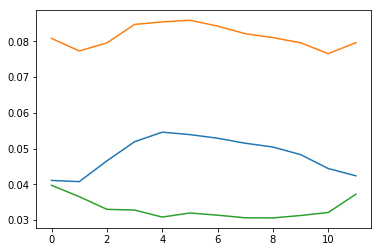

In [69]:
ds = get_monthly_oscar(lyr,0)
ds2 = get_monthly_oscar(lyr,1)
ds2=xr.Dataset(data_vars={'spd': (('time','lat','lon'),ds2.spd),'dir': (('time','lat','lon'),ds2.dir),
                         'v': (('time','lat','lon'),ds2.v),'u': (('time','lat','lon'),ds2.u)},
                coords={'lat':ds2.lat,'lon':ds2.lon,'time':ds.time})
plt.plot(ds_mean.spd - ds_mean_clim.spd)
plt.plot(ds_mean.spd )
plt.plot(ds_mean_clim.spd)

In [68]:
ds2

<xarray.Dataset>
Dimensions:  (lat: 481, lon: 1080, month: 12)
Coordinates:
  * lat      (lat) float64 -80.0 -79.67 -79.33 -79.0 ... 79.0 79.33 79.67 80.0
  * lon      (lon) float64 -180.0 -179.7 -179.3 -179.0 ... 179.0 179.3 179.7
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u        (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    v        (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    spd      (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    dir      (month, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [ ]:
#plot 5 data types are plotted for each region

ds = get_monthly_sst(lyr,0)
land_mask = ds.copy(deep=True)        
ds = get_monthly_ccmp(lyr,0)
land_mask2 = land_mask.interp_like(ds,method='nearest')

#read in mask file
filename = 'F:/data/NASA_biophysical/pices/shapefiles/pices/PICES_all_mask.nc'
ds_mask = xr.open_dataset(filename)
ds_mask.close()

#plot region sst map
#read in climatology sst
#for iregion in range(11,25):
for iregion in range(11,25):
    lyr=2018
    plt.figure(figsize=(13,6.2))
    for itype in range(0,6):
        if itype == 0:
            ds = get_monthly_oscar(lyr,1)
            ds.spd.attrs = {'long_name':'Curr. Vel. (cm/s)'}
            data_in = ds.spd[0,:,:]
        if itype == 1:
            ds = get_monthly_mld(lyr,1)
            ds.dbss_obml.attrs = {'long_name':'MLD (m)'}
            data_in = ds.dbss_obml[0,:,:]
        if itype == 2:
            ds = get_monthly_ccmp(lyr,1)
            ds.spd.attrs = {'long_name':'Wind Speed (m/s)'}
            ds = ds.where(np.isfinite(land_mask2.mask))
            data_in = ds.spd[0,:,:,0]
        if itype == 3:
            ds = get_monthly_sst(lyr,1)
            ds.analysed_sst.attrs = {'long_name':'SST (C)'}
            data_in = ds.analysed_sst[0,:,:]-273.15
            data_in.attrs = {'long_name':'SST (C)'}
        if itype == 4:
            ds = get_monthly_sss(lyr,1)
            ds.so.attrs = {'long_name':'Sal. (psu)'}
            data_in = ds.so[0,:,:]
        if itype == 5:
            ds = get_monthly_ssh(lyr,1)
            ds.zos.attrs = {'long_name':'SSH (m)'}
            data_in = ds.zos[0,:,:]

        mask_interp = ds_mask.interp_like(data_in,method='nearest')
        #mask_reg = mask_interp.rename({'region_mask':'mask'})
        #            cond = (mask_interp.region_mask==iregion)
        cond = (mask_interp.region_mask ==iregion)
        ds_mean = data_in.where(cond)
        #read in world map
        if itype==0:
            latmin=ds_mean.where(np.isfinite(ds_mean),drop=True).lat.min()-2
            latmax=ds_mean.where(np.isfinite(ds_mean),drop=True).lat.max()+2
            lonmin=ds_mean.where(np.isfinite(ds_mean),drop=True).lon.min()-2
            lonmax=ds_mean.where(np.isfinite(ds_mean),drop=True).lon.max()+2
            if ((iregion>=13) & (iregion<=15)):
                lonmin=ds_mean[:,900:].where(np.isfinite(ds_mean[:,900:]),drop=True).lon.min()-2
                lonmax=ds_mean[:,:900].where(np.isfinite(ds_mean[:,:900]),drop=True).lon.max()+2
        inumfig = 161+itype
        ax = plt.subplot(inumfig, projection=ccrs.Mercator(central_longitude=180,min_latitude=20, max_latitude=70))
        ax.background_img(name='ne_shaded', resolution='low')
        #ax.background_img(name='BM', resolution='high')
        ax.set_extent([lonmax,lonmin,latmin,latmax])
        if ((iregion>=13) | (iregion<=15)):
            ax.set_extent([lonmin,lonmax,latmin,latmax])
        mm = ax.pcolormesh(ds_mean.lon,\
                           ds_mean.lat,\
                           ds_mean, transform=ccrs.PlateCarree(),cmap='jet' )
        ax.coastlines(resolution='10m');
        plt.colorbar(mm,ax=ax,shrink=.95,pad=.01,orientation="horizontal",label=data_in.long_name)
        if itype==2:
            plt.title('PICES region '+str(iregion))
    plt.savefig('F:/data/NASA_biophysical/pices/figures/pices_shapefiles_show_data'+str(itype)+str(iregion)+'.png')



In [5]:
#read in data to make time series
data_type= '_pices_data_v2.nc'
data_type2= '_pices_data_minus_clim_v2.nc'
dtype = 'oscar'
filename = dir_timeseries + dtype + data_type
ds_oscar = xr.open_dataset(filename)
ds_oscar.close()
filename = dir_timeseries + dtype + data_type2
ds_oscar_clim = xr.open_dataset(filename)
ds_oscar_clim.close()
dtype = 'sst'
filename = dir_timeseries + dtype + data_type
ds_sst = xr.open_dataset(filename)
ds_sst.close()
filename = dir_timeseries + dtype + data_type2
ds_sst_clim = xr.open_dataset(filename)
ds_sst_clim.close()
dtype = 'ccmp'
filename = dir_timeseries + dtype + data_type
ds_ccmp = xr.open_dataset(filename)
ds_ccmp.close()
filename = dir_timeseries + dtype + data_type2
ds_ccmp_clim = xr.open_dataset(filename)
ds_ccmp_clim.close()
dtype = 'sss'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'sss', dir_timeseries + dtype + data_type
ds_sss = xr.open_dataset(filename)
ds_sss.close()
filename = dir_timeseries + dtype + data_type2
ds_sss_clim = xr.open_dataset(filename)
ds_sss_clim.close()
dtype = 'mld'
filename = dir_timeseries + dtype + data_type
dtype, filename = 'mld', dir_timeseries + dtype + data_type
ds_mld = xr.open_dataset(filename)
ds_mld.close()
filename = dir_timeseries + dtype + data_type2
ds_mld_clim = xr.open_dataset(filename)
ds_mld_clim.close()


In [6]:
ds_ccmp_clim.sel(region=14)

<xarray.Dataset>
Dimensions:        (time: 312)
Coordinates:
  * time           (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2018-12-31
    month          (time) int64 ...
    region         int32 14
Data variables:
    uwnd           (time) float32 ...
    vwnd           (time) float32 ...
    spd            (time) float32 ...
    dir            (time) float32 ...
    dx_grid        (time) float64 ...
    dy_grid        (time) float64 ...
    rel_vorticity  (time) float64 ...

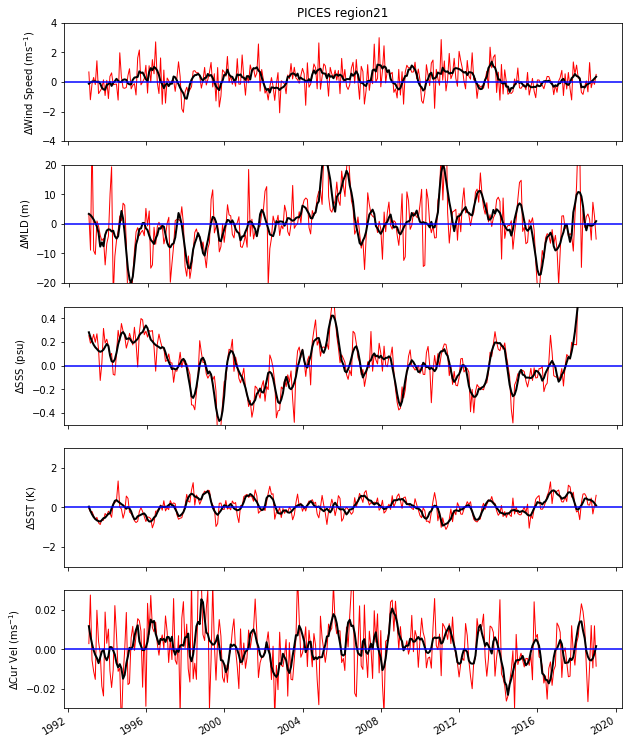

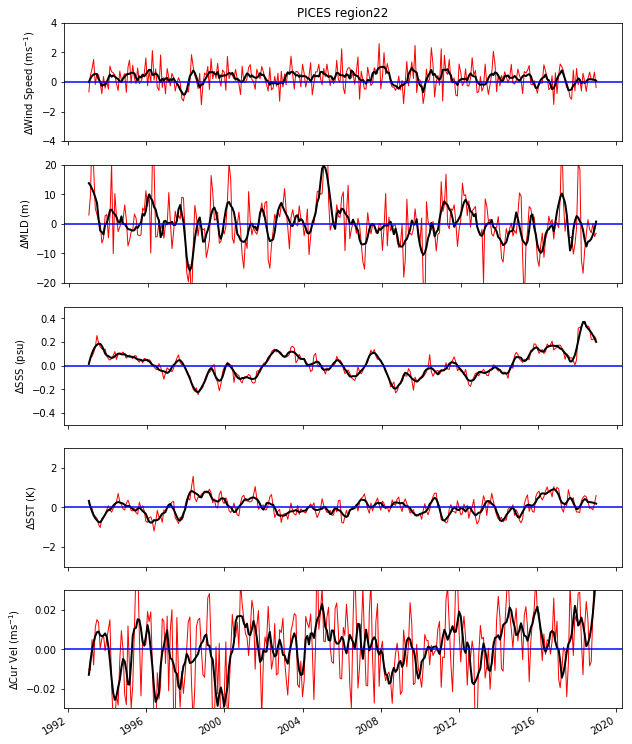

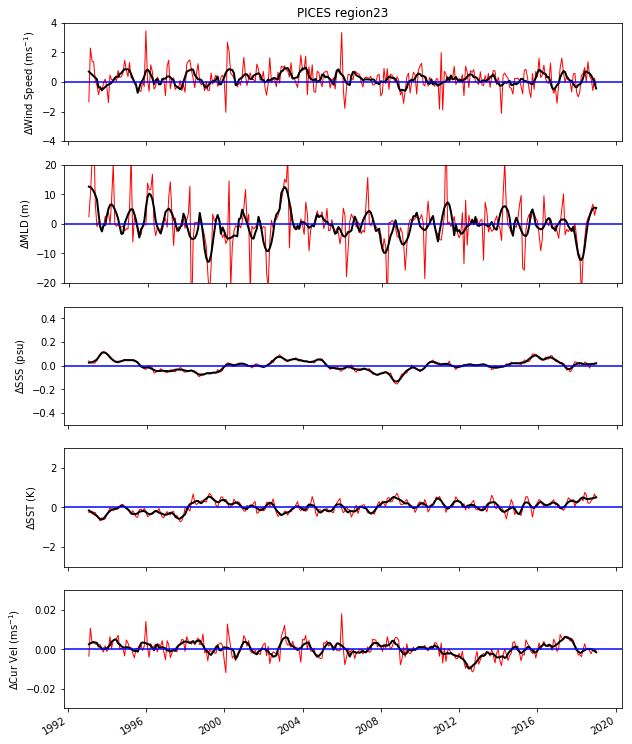

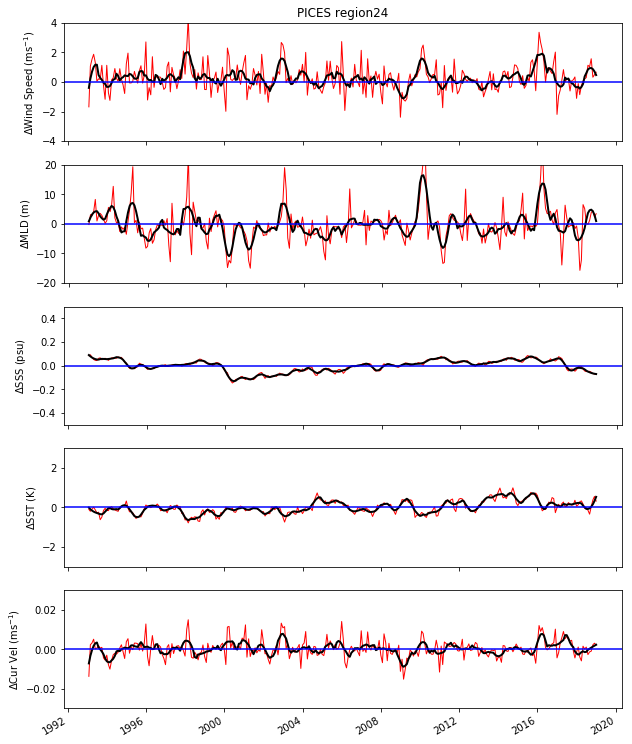

In [15]:
#plot only anomalies, use variable latitudes
#fig.clf()
for iregion in range(21,25):  #use var lat ratehr than static npc & bi
    fig, axarr = plt.subplots(5,figsize=(10,14))
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp_clim
            ax = axarr[icol]
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_title('PICES region'+str(iregion))
           # if iregion==5:
            ax.set_ylabel('$\Delta$Wind Speed (ms$^{-1}$)')
            #else:
           #     ax.set_yticklabels('')
            #ax.set_xticklabels('')
            ax.set_ylim(-4,4)
        if icol==1:
            ds = ds_mld_clim
            ax = axarr[icol]
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            #if iregion==5:
            ax.set_ylabel('$\Delta$MLD (m)')
            #else:
            #    ax.set_yticklabels('')
            #ax.set_xticklabels('')
            ax.set_ylim(-20,20)
        if icol==2:
            ds = ds_sss_clim
            ax = axarr[icol]
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            #if iregion==5:
            ax.set_ylabel('$\Delta$SSS (psu)')
            #else:
            #    ax.set_yticklabels('')
            #ax.set_xticklabels('')
            ax.set_ylim(-.5,.5)
        if icol==3:
            ds = ds_sst_clim
            ax = axarr[icol]
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax.plot(ds.time[:],tem.analysed_sst, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            #if iregion==5:
            ax.set_ylabel('$\Delta$SST (K)')
            #else:
             #   ax.set_yticklabels('')
            #ax.set_xticklabels('')
            ax.set_ylim(-3,3)
        if icol==4:
            ds = ds_oscar_clim
            ax = axarr[icol]
            tem = ds.sel(region=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            #if iregion==5:
            ax.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
            #else:
             #   ax.set_yticklabels('')
            ax.set_ylim(-0.03,0.03)
        if icol==5:
            #ds = ds_oscar
            ds = ds_oscar_clim
            ax = axarr[icol]
            tem = ds.sel(region=iregion)
#            tem,tem2 = ds.isel(box=iregion),ds2.isel(box=iregion)
            #dif = tem - tem2
            ds_smoothed = savgol_filter(tem.dir, 11, 2)
            ax.plot(ds.time[:],tem.dir, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            #if iregion==5:
            ax.set_ylabel('$\Delta$Cur Dir ($\circ$)')
            #else:
            #    ax.set_yticklabels('')
            ax.set_ylim(-180,180)
    fig.autofmt_xdate()
    fig.savefig(dir_figs + '_pices_'+str(iregion)+'timeseries_anomaly.png', dpi=100)

In [ ]:
fig, axarr = plt.subplots(6, 5,figsize=(10,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,15)
            ax2.set_ylim(-5,5)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[1,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax.plot(ds.time[:],ds.dbss_obml[iregion,:]
                                   -ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            if iregion==4:
                ax2.set_ylabel('$\Delta$MLD (m)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(0,120)
            ax2.set_ylim(-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[2,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.so[iregion,:]
                                   -ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==4:
                ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(31,33.5)
            ax2.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[3,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.analysed_sst[iregion,:]
                                   -ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            ax2.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[4,ax_order[iregion]]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(0,.15)
            ax2.set_ylim(-0.03,0.03)
        if icol==4:
            ds = ds_oscar
            ds2 = ds_oscar_clim
            ax = axarr[5,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dir, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('$\Delta$Cur Dir ($\circ$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Cur Dir ($\circ$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-180,180)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'pices_timeseries_anomaly2.png', dpi=100)

In [ ]:
len(ds.time)

In [ ]:
fig, ax = plt.subplots(5, 1,figsize=(18, 4))
for iregion in range(0,5):
    ax.subplot(511)
    ax.plot(ds.time[:], ds.spd[iregion,:], linewidth=2, color='blue')
    arrow_scaler = 3
    for i in range(0,len(ds.time),1):
        u = arrow_scaler*ds.u[iregion,i] #-1*np.sin((np.pi/180)*(ds.dir[iregion,i]))
        v = arrow_scaler*ds.v[iregion,i] #-1*np.cos((np.pi/180)*(ds.dir[iregion,i]))
     #   ax.arrow(ds.time[i],(ds.spd[iregion,i].max()+2)/2, u, v, fc='k', ec='k', head_width=0.4, head_length=0.6)
        plt.quiver(ds.time[i].values,ds.spd[iregion,:].mean(),u.values,v.values,width=0.001)

In [ ]:
u

In [ ]:
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC2','NPC-bi2']
fig, axarr = plt.subplots(5, 7,figsize=(10,14))
#fig.clf()
for iregion in range(0,7):
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,iregion]
#            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Data',color='blue',linewidth=1)
#            ax.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.spd[iregion,:]
            #                       -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==6:
                ax.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                #ax.set_yticklabels('')
            elif iregion==0:
                #ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                #ax2.set_yticklabels('')
                ax.set_yticklabels('')
            #ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,15)
            #ax2.set_ylim(-5,5)
#            ax.set_xlim(2000,2019)
#            ax2.set_xlim(2000,2019)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[1,iregion]
           # ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#            ax.plot(ds.time[:],ds.dbss_obml[iregion,:]
#                                   -ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            if iregion==6:
             #   ax2.set_ylabel('$\Delta$MLD (m)')
                ax.set_yticklabels('')
            elif iregion==0:
             #   ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
             #   ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(0,140)
            #ax2.set_ylim(-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
#            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly Smoothed',color='blue',linewidth=1)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.so[iregion,:]
            #                       -ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==6:
              #  ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==0:
               # ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                #ax2.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(31,33.8)
            #ax2.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
  #          ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax.plot(ds.time[:],tem.analysed_sst-273.15, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.analysed_sst[iregion,:]
            #                       -ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==6:
             #   ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==0:
              #  ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
               # ax2.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            #ax2.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[4,iregion]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            #ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
           # ax.plot(ds.time[:],ds.spd[iregion,:]
           #                        -ds_clim.spd[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==6:
           #     ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
           #     ax2.set_yticklabels('')
                ax.set_ylabel('Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
           #     ax2.set_yticklabels('')
            ax.set_ylim(0,.15)
           # ax2.set_ylim(-0.03,0.03)
        #    axarr[iregion, 0].legend()
          #  for tick in ax.get_xticklabels():
          #      tick.set_rotation(45)#fig.show()
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_data.png', dpi=100)

In [ ]:
#same type of figure but this time show wind spd, u, v, dir from ccmp data
fig, axarr = plt.subplots(4, 7,figsize=(10,14))
#fig.clf()
for iregion in range(0,7):
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.spd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            #ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==6:
                ax2.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,12.5)
            ax2.set_ylim(-2,2)
        if icol==0:
            ax = axarr[1,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.uwnd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            #ax2.plot(ds.time[:],ds_clim.uwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.uwnd[iregion,:]
                                   -ds_clim.uwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('U Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('U Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-5,5)
        if icol==1:
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.vwnd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.vwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.vwnd[iregion,:]
                                   -ds_clim.vwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('V Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('V Wind Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-5,5)
        if icol==2:
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.dir[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.dir[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('Wind Dir Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Dir (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-90,90)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'CCMP_timeseries.png', dpi=100)

In [ ]:
ds_oscar_clim

In [ ]:
from scipy.signal import savgol_filter

#same type of figure but this time show current spd, u, v, dir from oscar data
fig, axarr = plt.subplots(4, 5,figsize=(10,10))
#fig.clf()
for iregion in range(0,5):
    for icol in range(0,5):
        if icol==0:
            ds = ds_oscar.mean('depth')
            ds_clim = ds_oscar_clim.mean('depth')
            ax = axarr[0,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.spd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            #ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Current Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0.04,.12)
            ax2.set_ylim(-.1,.1)
        if icol==0:
            ax = axarr[1,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.u[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            #ax2.plot(ds.time[:],ds_clim.uwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.u[iregion,:]
                                   -ds_clim.u[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('U Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('U Current Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-.055,.055)
            ax2.set_ylim(-.02,.02)
        if icol==1:
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.v[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.vwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.v[iregion,:]
                                   -ds_clim.v[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('V Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('V Current Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-.055,.055)
            ax2.set_ylim(-.02,.02)
        if icol==2:
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.dir[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.dir[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],(ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:]),label = 'Climatology',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('Current Dir Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Current Dir (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-90,90)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'OSCAR_timeseries.png', dpi=100)

In [ ]:
R = 6.37e6 #radius of earth in m
# we know already that the spacing of the points is 1/4 degree latitude
grid_dy,grid_dx = (ds.lat[0]-ds.lat[1]).data,(ds.lon[0]-ds.lon[1]).data
dϕ = np.deg2rad(grid_dy)
dλ = np.deg2rad(grid_dx)
dA = R**2 * dϕ * dλ * np.cos(np.deg2rad(ds.lat)) #dA.plot()
pixel_area = dA.where(cond & np.isfinite(ds.zos[0,:,:])  
pixel_area.plot()
pixel_area = dA.where(cond)  
pixel_area = pixel_area.where(np.isfinite(ds.zos[0,:,:]))
pixel_area.plot()sst_weighted_mean.zos.plot()